# Post Meeting Plots
---
This notebook generates plots that aim to answer questions asked by Nathan during the October meeting

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from postreise.process import transferdata as td
from postreise.plot.analyze_pg import AnalyzePG as apg
from westernintnet.westernintnet import win_data

c:\program files\python\python36\lib\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


Loading sub
Loading bus2sub
Loading bus
Loading genbus
Loading branches
Loading resources
Loading net_generation
Done loading


In [2]:
od = td.OutputData()
pg = od.get_data('western_scenarioBaseCase01', 'PG')

win_data.read_demand_data('v2')
win_data.read_solar_data('naive')
win_data.read_wind_data()

multiplier = pd.DataFrame({'multiplier': [1]*len(win_data.genbus)}, index=win_data.genbus.index.values)

Use  C:\Users\brdo\scenario_data\  to save/load local scenario data.
Load demand data
Load solar data
Load wind data


## 1. Solar Power Generated in California

The plots below are normalized such that it is 1 when the solar power generated (in MWh) is equal to the capacity of the solar plants (in MW) times the number of hours considered.

### A. One set of plants

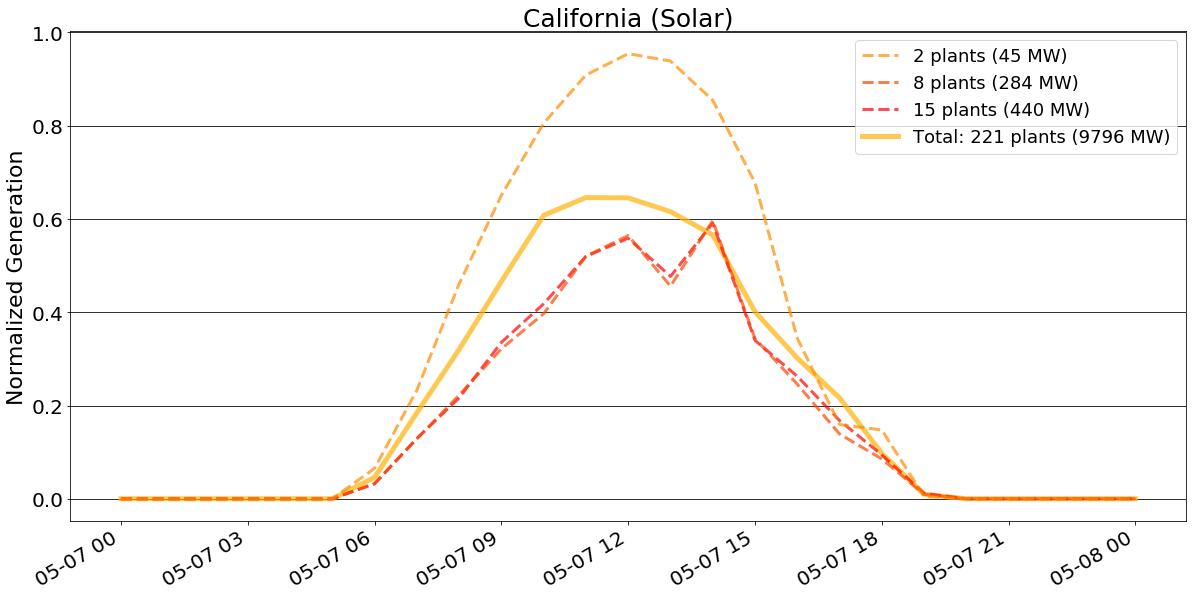

In [3]:
apg((pg, win_data, multiplier),
    ('2016-05-07-00', '2016-05-08-00', 'local', 'H'),
    ['California'],
    ['solar'],
    'variability', normalize=True, seed=0).get_plot(save=False)

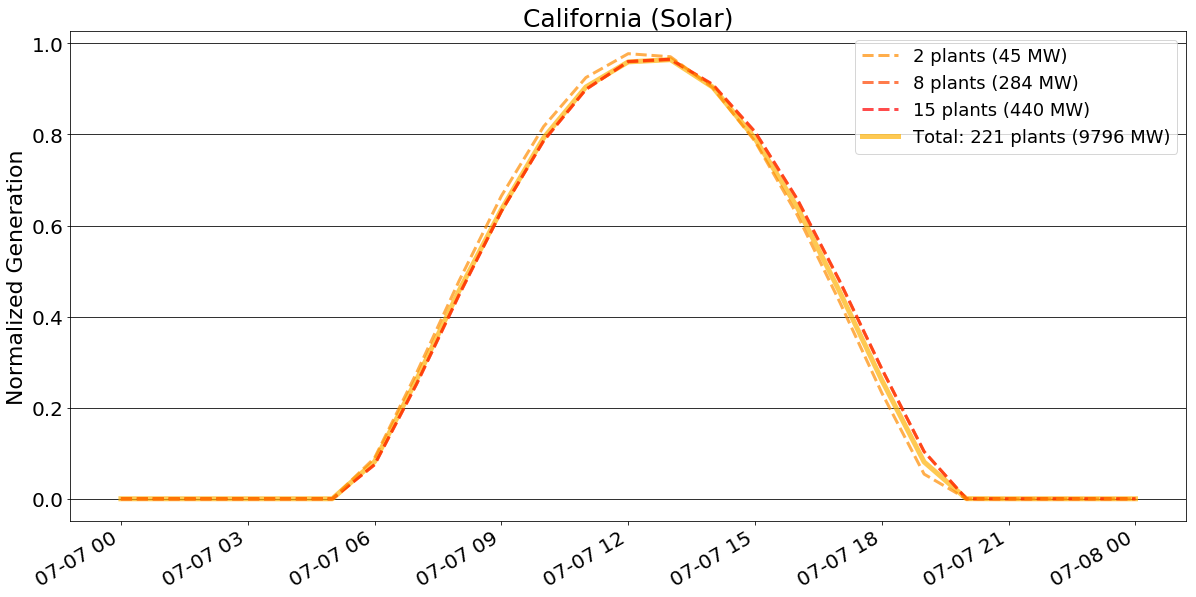

In [4]:
apg((pg, win_data, multiplier),
    ('2016-07-07-00', '2016-07-08-00', 'local', 'H'),
    ['California'],
    ['solar'],
    'variability', normalize=True, seed=0).get_plot(save=False)

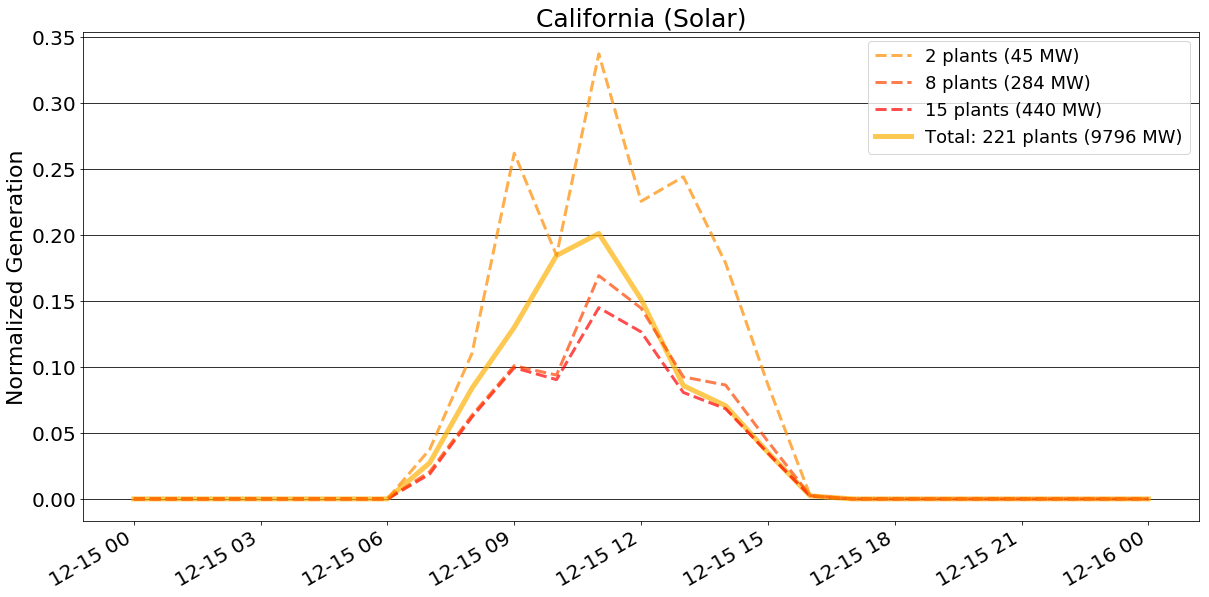

In [5]:
apg((pg, win_data, multiplier),
    ('2016-12-15-00', '2016-12-16-00', 'local', 'H'),
    ['California'],
    ['solar'],
    'variability', normalize=True, seed=0).get_plot(save=False)

### B. Other set of plants

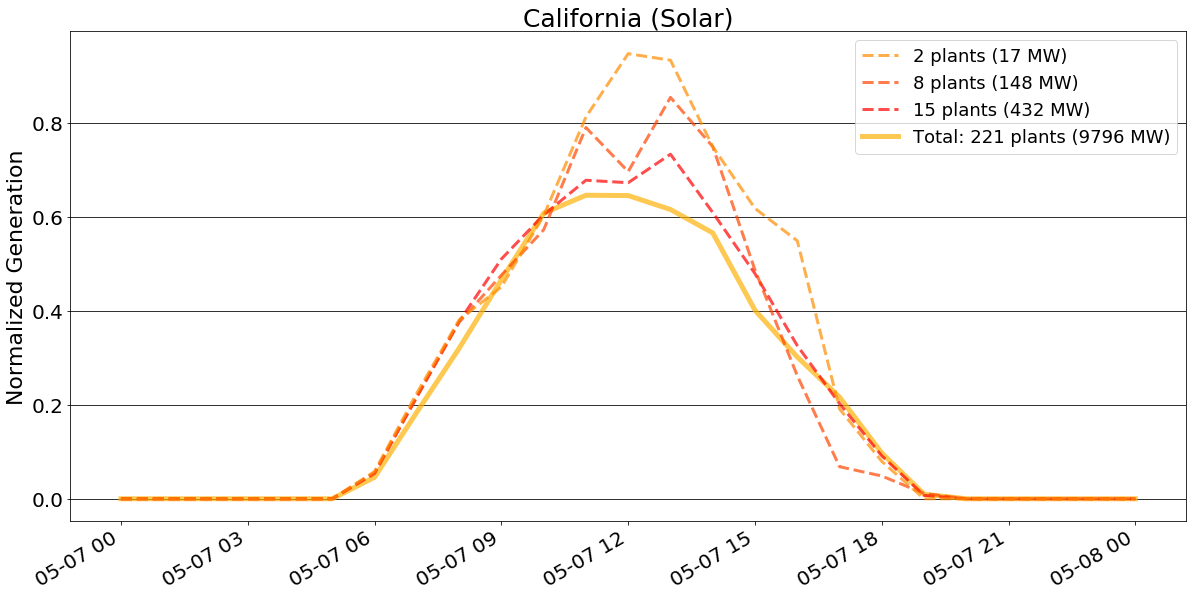

In [6]:
apg((pg, win_data, multiplier),
    ('2016-05-07-00', '2016-05-08-00', 'local', 'H'),
    ['California'],
    ['solar'],
    'variability', normalize=True, seed=10).get_plot(save=False)

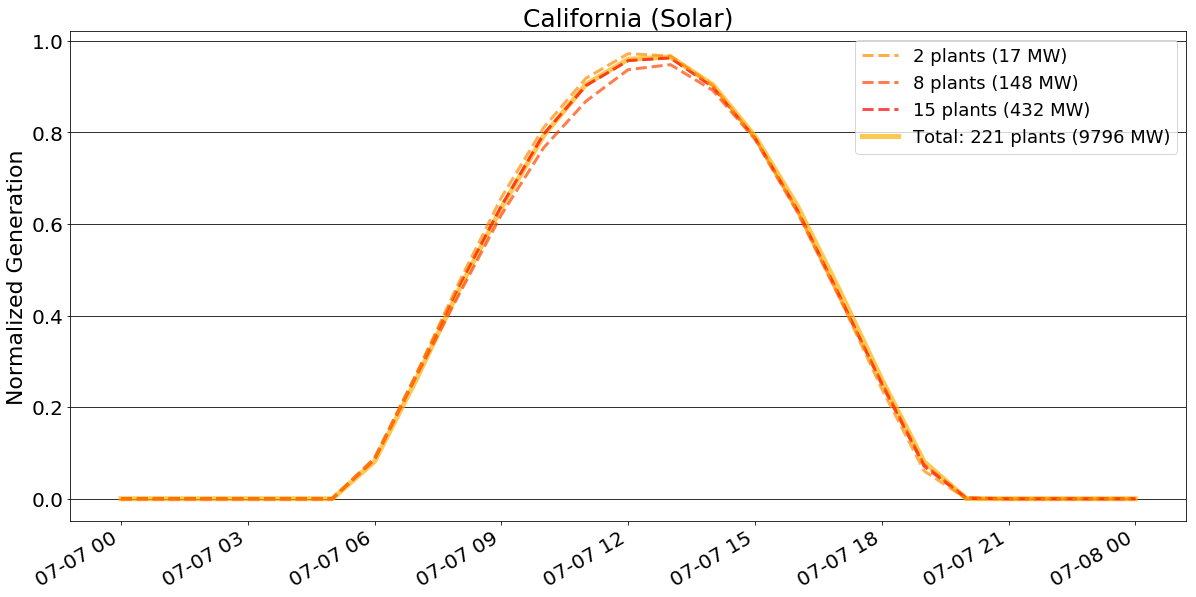

In [7]:
apg((pg, win_data, multiplier),
    ('2016-07-07-00', '2016-07-08-00', 'local', 'H'),
    ['California'],
    ['solar'],
    'variability', normalize=True, seed=10).get_plot(save=False)

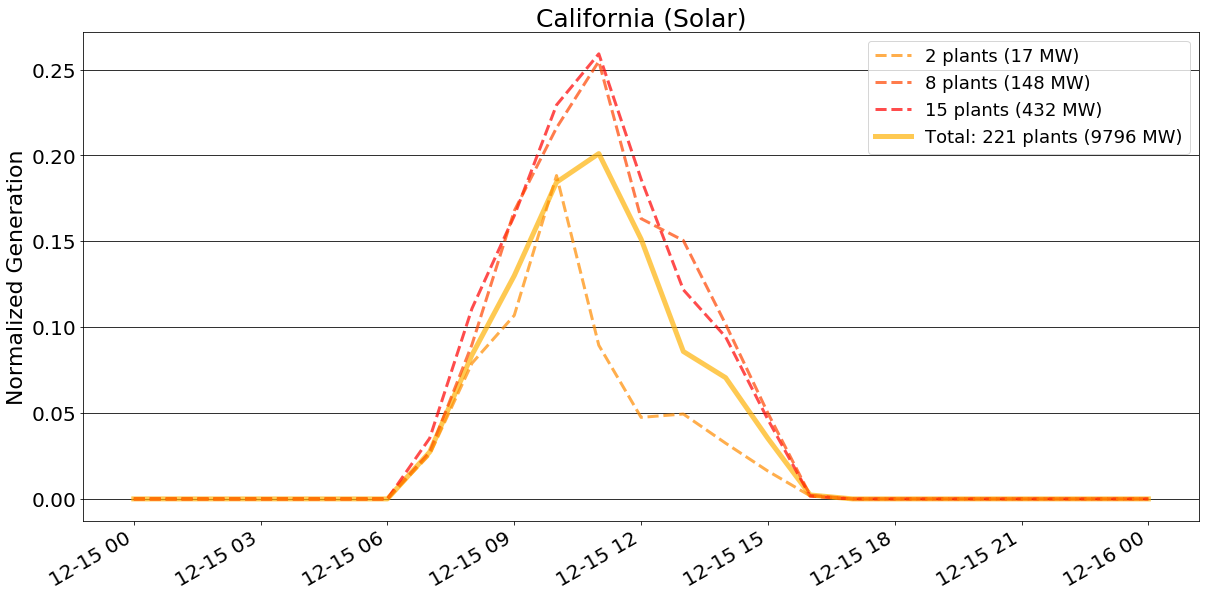

In [8]:
apg((pg, win_data, multiplier),
    ('2016-12-15-00', '2016-12-16-00', 'local', 'H'),
    ['California'],
    ['solar'],
    'variability', normalize=True, seed=10).get_plot(save=False)

## 2. Wind Power Generated in California

The plots below are normalized such that it is 1 when the wind power generated (in MWh) is equal to the capacity of the wind farms (in MW) times the number of hours considered.

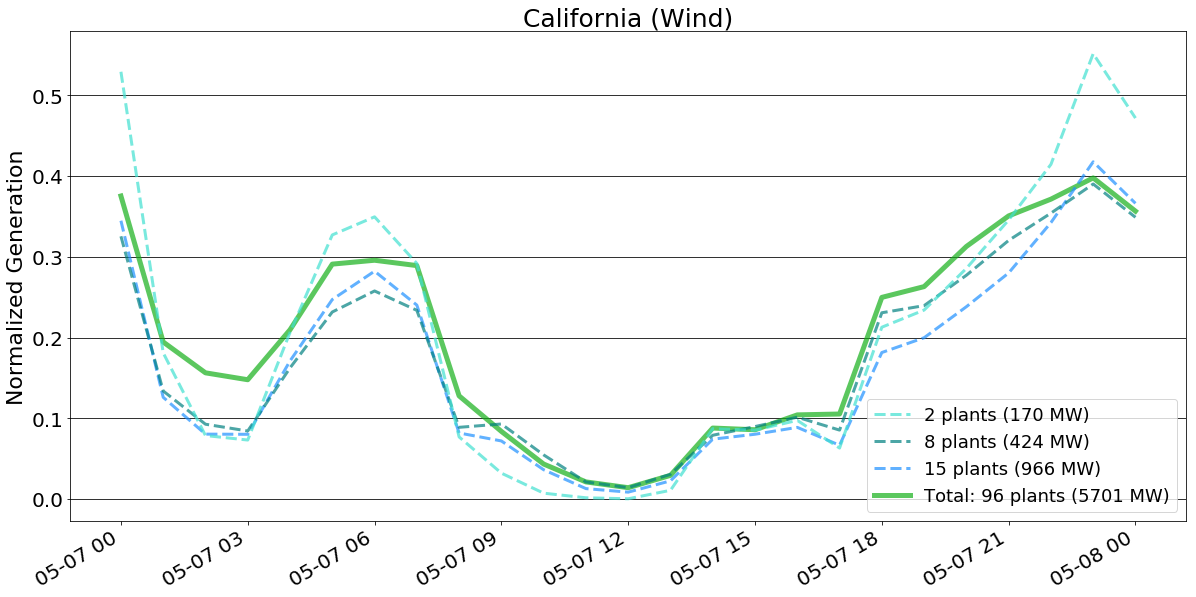

In [9]:
apg((pg, win_data, multiplier),
    ('2016-05-07-00', '2016-05-08-00', 'local', 'H'),
    ['California'],
    ['wind'],
    'variability', normalize=True, seed=0).get_plot(save=False)

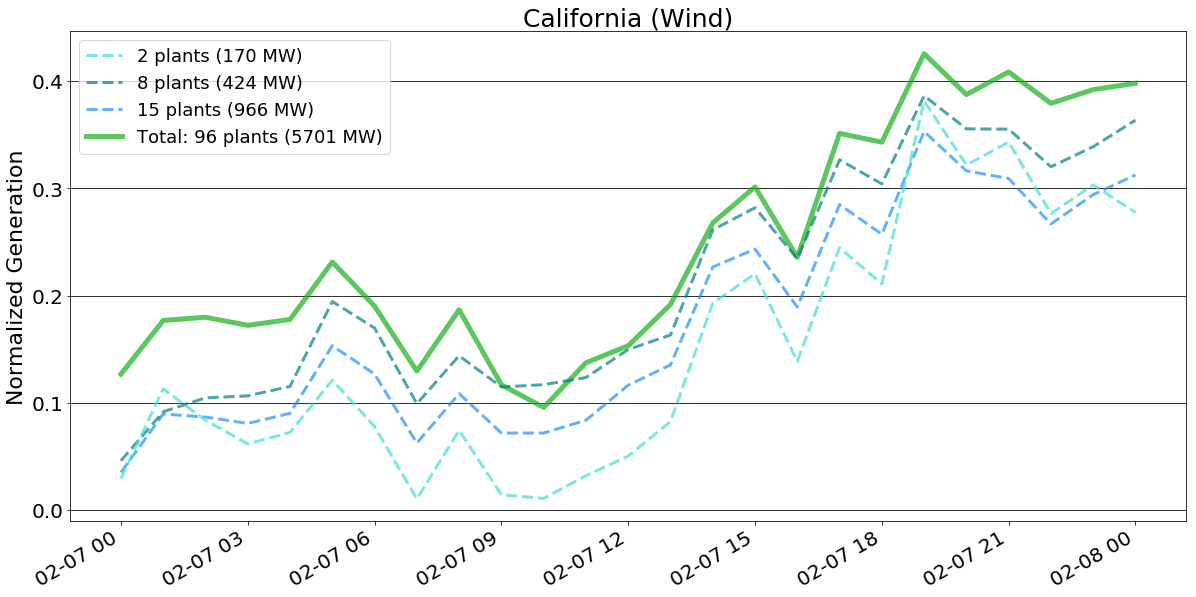

In [10]:
apg((pg, win_data, multiplier),
    ('2016-02-07-00', '2016-02-08-00', 'local', 'H'),
    ['California'],
    ['wind'],
    'variability', normalize=True, seed=0).get_plot(save=False)

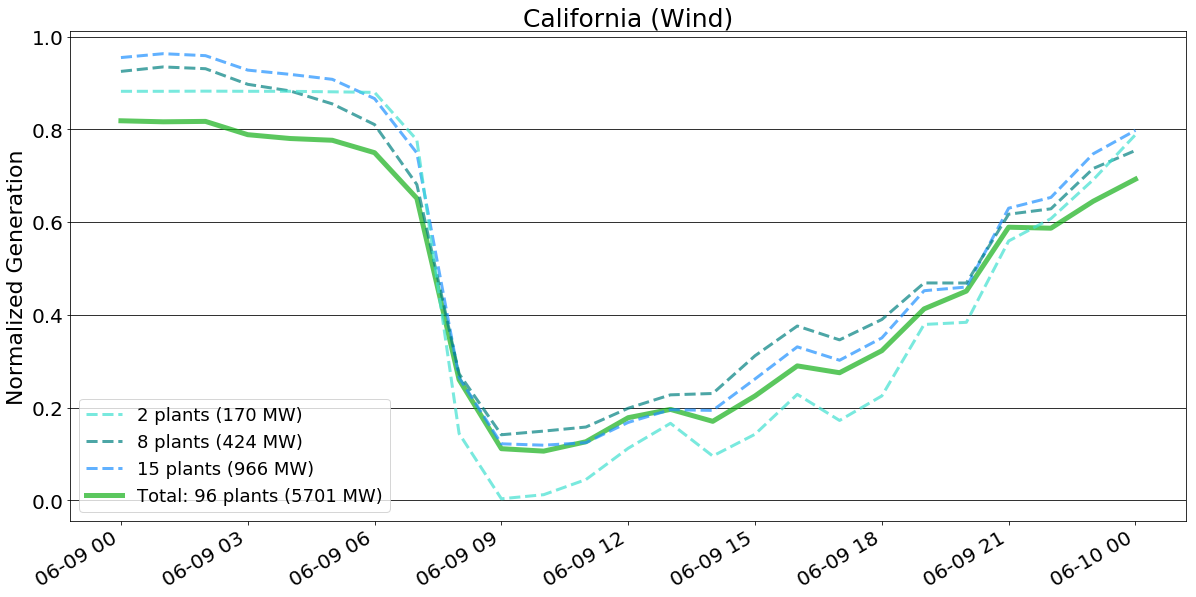

In [11]:
apg((pg, win_data, multiplier),
    ('2016-06-09-00', '2016-06-10-00', 'local', 'H'),
    ['California'],
    ['wind'],
    'variability', normalize=True, seed=0).get_plot(save=False)

## 3. Correlation of Solar Power Generated across States

### A. Year

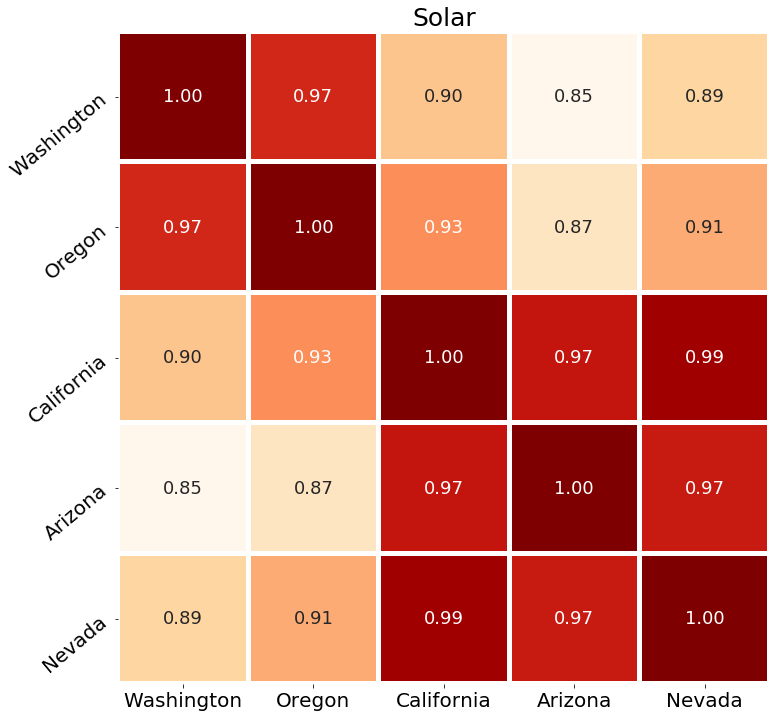

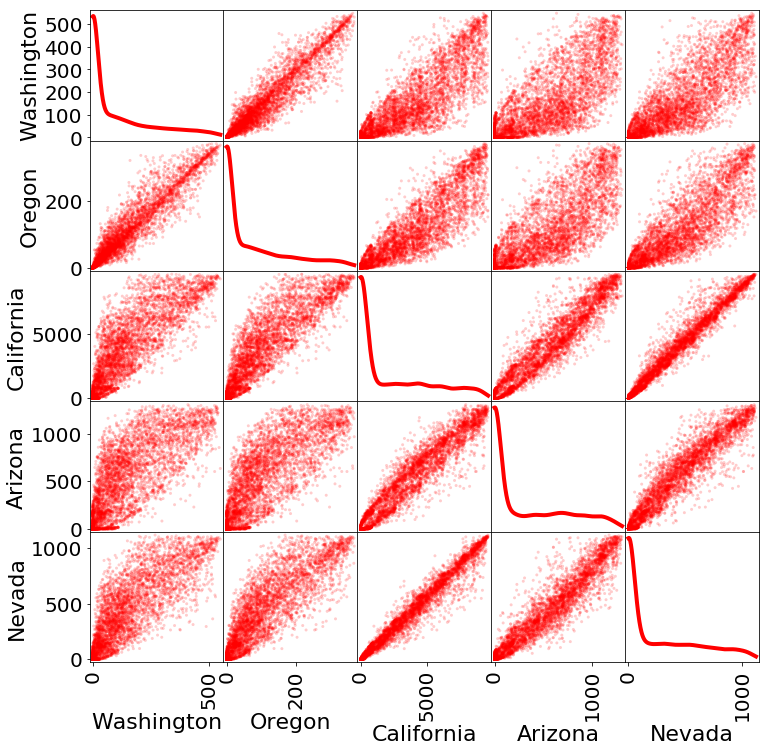

In [12]:
corr_solar = apg((pg, win_data, multiplier),
                 ('2016-01-01-00', '2016-12-31-23', 'utc', 'H'),
                 ['Washington', 'Oregon', 'California', 'Arizona', 'Nevada'],
                 ['solar'],
                 'correlation')
corr_solar.get_plot(save=False)
data_corr_solar = corr_solar.get_data()

In [13]:
data_corr_solar['solar'].corr()

,Washington,Oregon,California,Arizona,Nevada
Washington,1.000000,0.965907,0.899538,0.850804,0.886569
Oregon,0.965907,1.000000,0.925330,0.872510,0.913486
California,0.899538,0.925330,1.000000,0.973098,0.988207
Arizona,0.850804,0.872510,0.973098,1.000000,0.970440
Nevada,0.886569,0.913486,0.988207,0.970440,1.000000


### B. Day

In [14]:
def get_plant_id(zone, resource):
    plant_id = []
    if zone == 'Western':
        try:
            plant_id = win_data.genbus.groupby('type').get_group(resource).index.values.tolist()
        except KeyError:
            pass
    elif zone == 'California':
        CA = ['Bay Area', 'Central California', 'Northern California',
              'Southeast California', 'Southwest California']
        for load_zone in CA:
            try:
                plant_id += win_data.genbus.groupby(['ZoneName', 'type']).get_group(
                    (load_zone, resource)).index.values.tolist()
            except KeyError:
                pass
    else:
        try:
            plant_id = win_data.genbus.groupby(['ZoneName', 'type']).get_group(
                (zone, resource)).index.values.tolist()
        except KeyError:
            pass
    
    return plant_id


def get_pg_zone(pg, zones, resource):
    for i, z in enumerate(zones):
        plant_id = get_plant_id(z, resource)
        if len(plant_id) == 0:
            print("No %s plants in %s" % (resource, z))
            return
        if i == 0:
            pg_zone = pd.DataFrame({z: pg[plant_id].sum(axis=1).values}, index=pg.index)
        else:
            pg_zone[z] = pg[plant_id].sum(axis=1).values

    pg_zone.index.name = 'UTC'

    return pg_zone

In [15]:
from datetime import datetime, timedelta

start = datetime.strptime('2016-01-01', '%Y-%m-%d')
end = datetime.strptime('2016-12-31', '%Y-%m-%d')
step = timedelta(days=1)

In [16]:
corr = []
while start <= end:
    pg_tmp = pg[start:start+step]
    corr.append(get_pg_zone(pg_tmp, ['Washington','Oregon','California','Arizona','Nevada'], 'solar').corr())
    plt.close('all')
    start += step

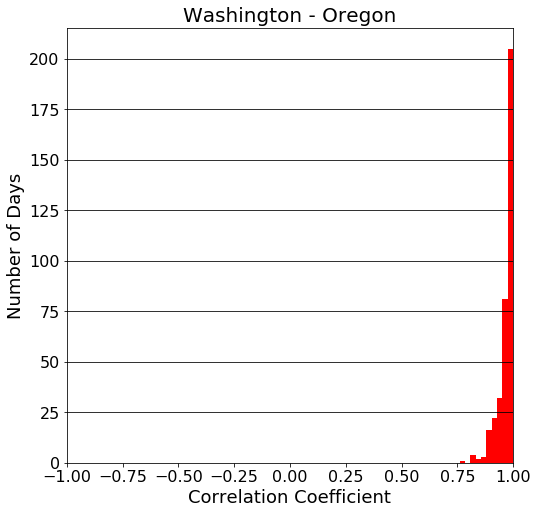

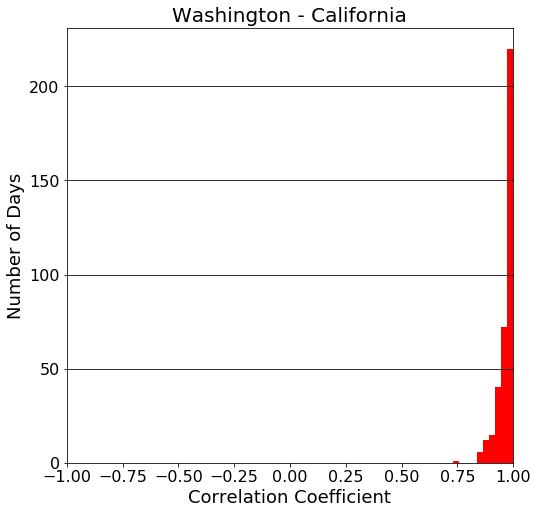

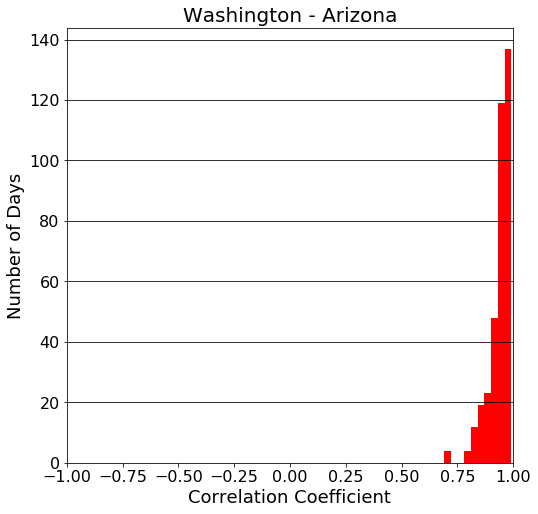

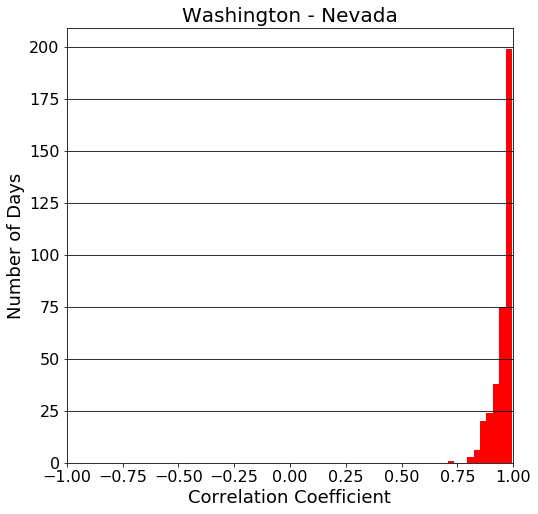

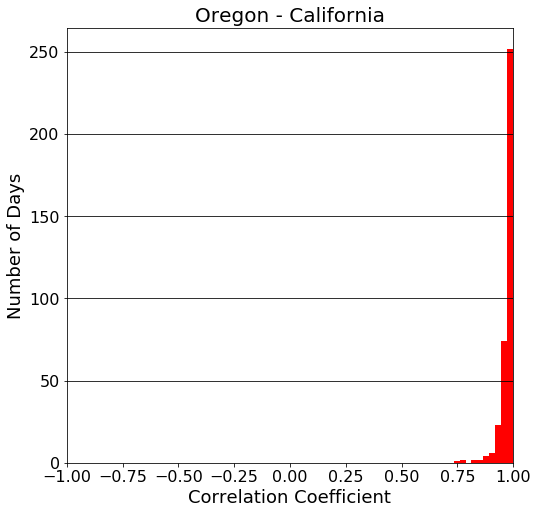

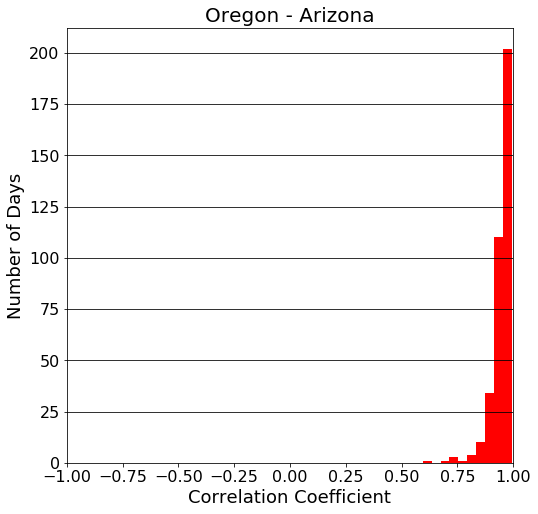

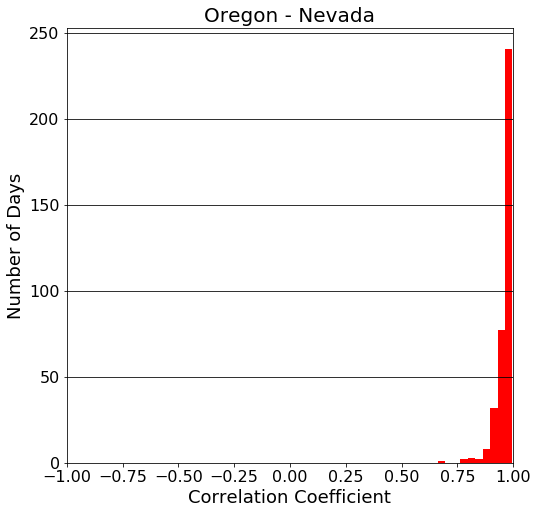

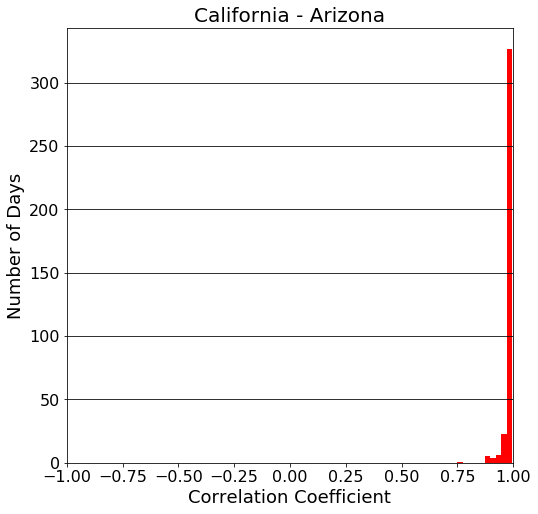

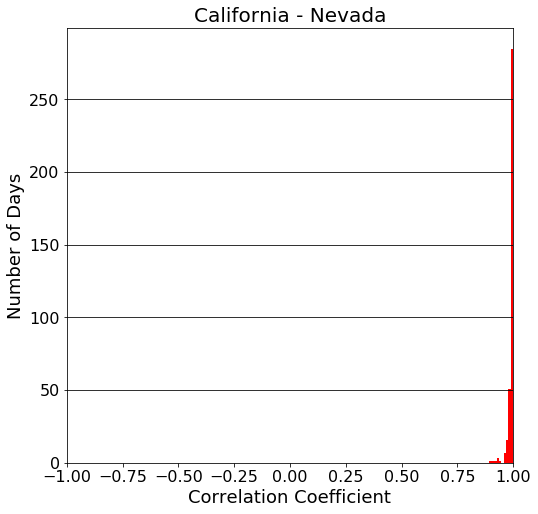

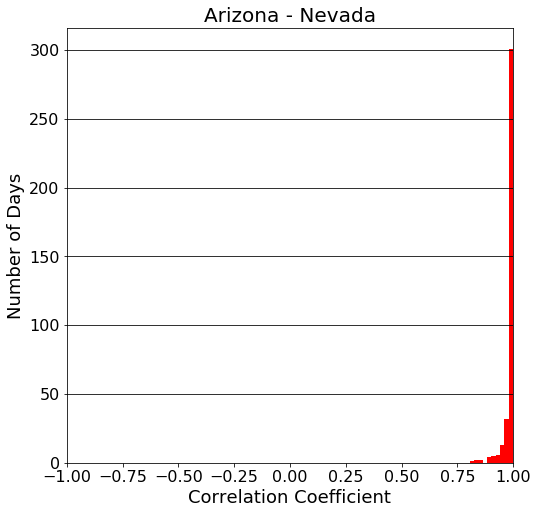

In [17]:
import itertools
pairs = list(itertools.combinations(data_corr_solar['solar'].columns.tolist(), 2))
for p in pairs:
    fig = plt.figure(figsize=(8, 8))
    plt.hist([corr[i].loc[p[0]][p[1]] for i in range(len(corr))], 10, color='r')
    ax = fig.gca()
    ax.set_xlim([-1,1])
    ax.set_facecolor('white')
    ax.grid(color='black', axis='y')
    ax.tick_params(labelsize=16)
    ax.set_xlabel('Correlation Coefficient', fontsize=18)
    ax.set_ylabel('Number of Days', fontsize=18)
    plt.title(" - ".join(p), fontsize=20)
plt.show()

## 2. Correlation of Wind Power Generated across States

### A. Year

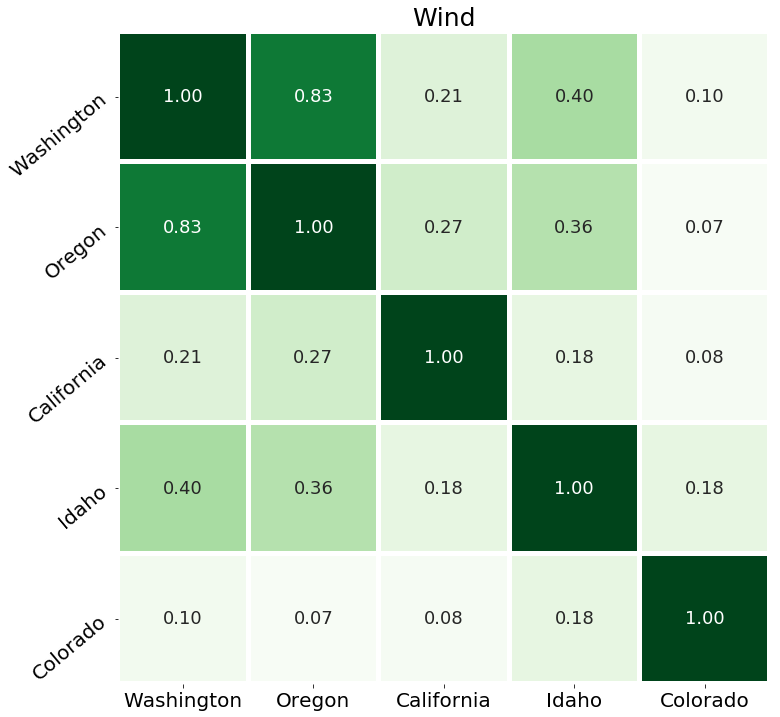

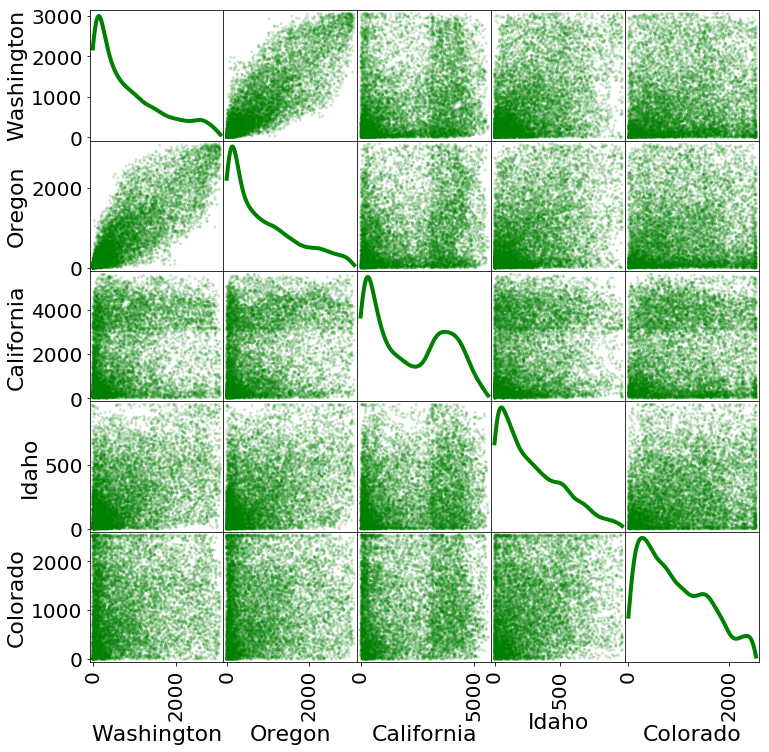

In [18]:
corr_wind = apg((pg, win_data, multiplier),
                 ('2016-01-01-00', '2016-12-31-23', 'utc', 'H'),
                 ['Washington', 'Oregon', 'California', 'Idaho', 'Colorado'],
                 ['wind'],
                 'correlation')
corr_wind.get_plot(save=False)
data_corr_wind = corr_wind.get_data()

In [19]:
data_corr_wind['wind'].corr()

,Washington,Oregon,California,Idaho,Colorado
Washington,1.000000,0.833675,0.213932,0.401380,0.104864
Oregon,0.833675,1.000000,0.269699,0.361422,0.071854
California,0.213932,0.269699,1.000000,0.179846,0.082959
Idaho,0.401380,0.361422,0.179846,1.000000,0.180177
Colorado,0.104864,0.071854,0.082959,0.180177,1.000000


### B. Day

In [20]:
from datetime import datetime, timedelta

start = datetime.strptime('2016-01-01', '%Y-%m-%d')
end = datetime.strptime('2016-12-31', '%Y-%m-%d')
step = timedelta(days=1)

In [21]:
corr = []
while start <= end:
    pg_tmp = pg[start:start+step]
    corr.append(get_pg_zone(pg_tmp, ['Washington','Oregon','California','Idaho','Colorado'], 'wind').corr())
    plt.close('all')
    start += step

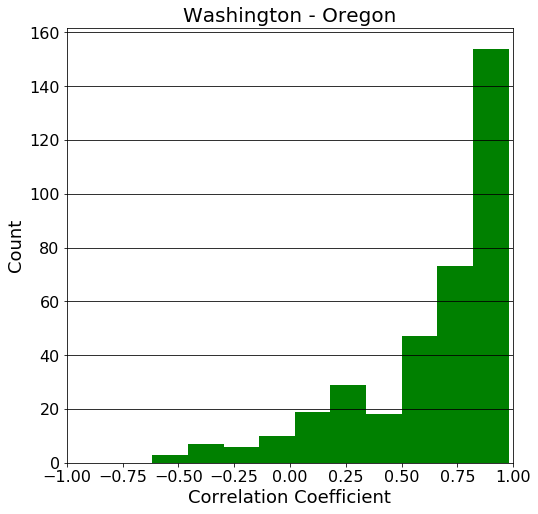

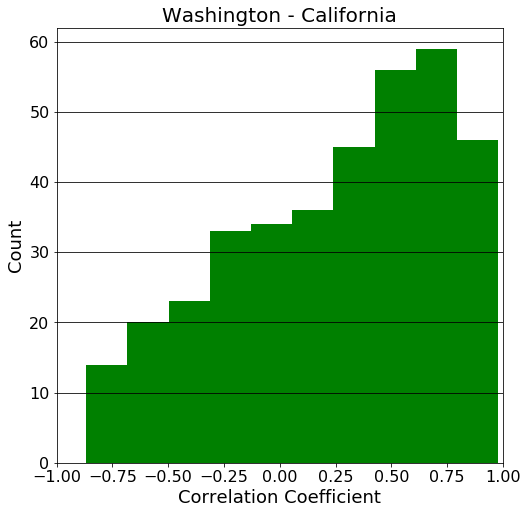

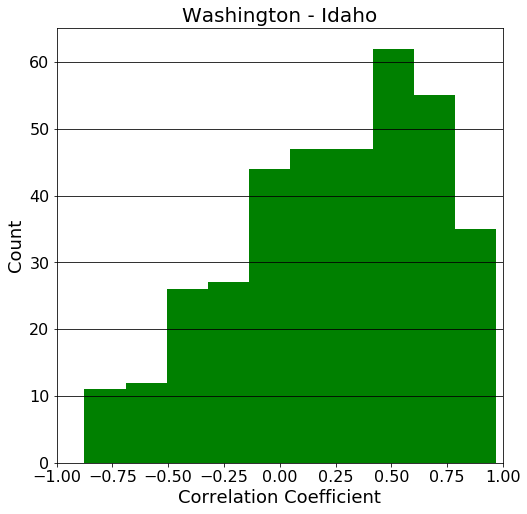

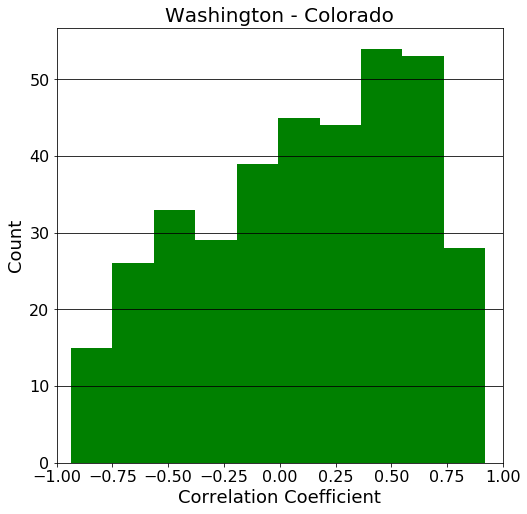

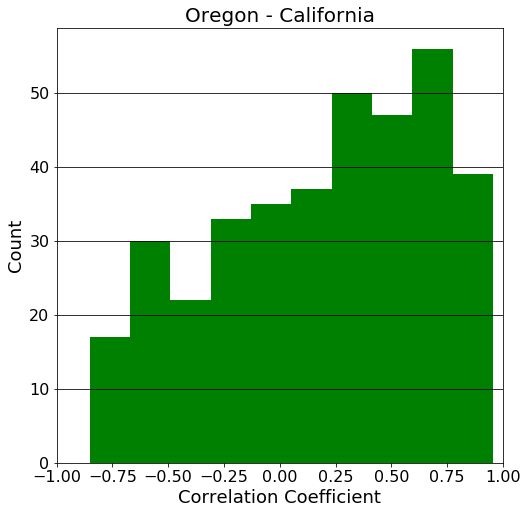

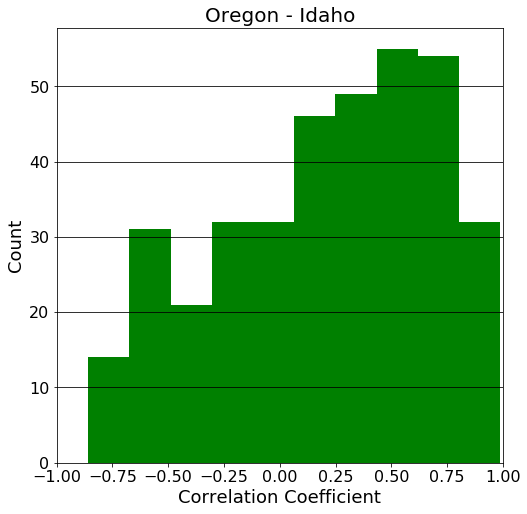

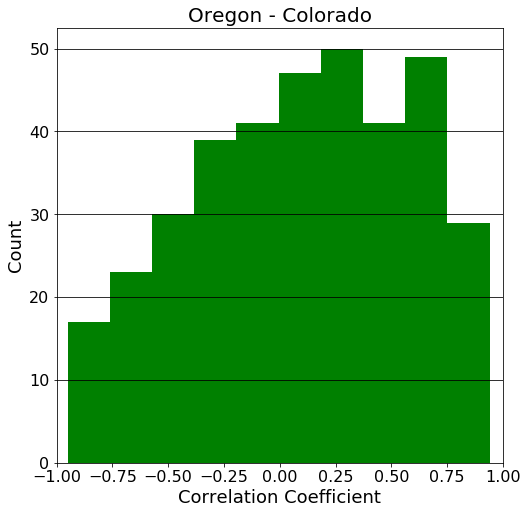

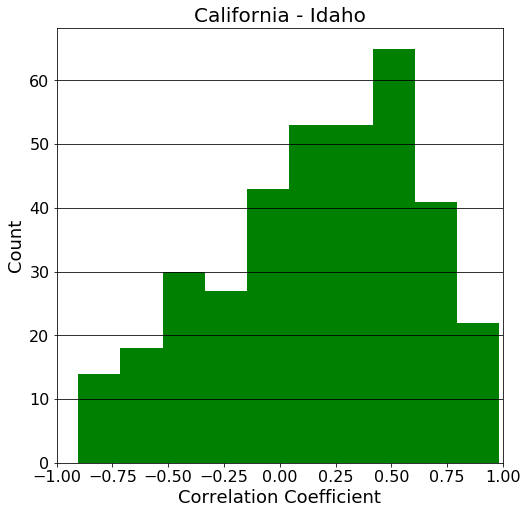

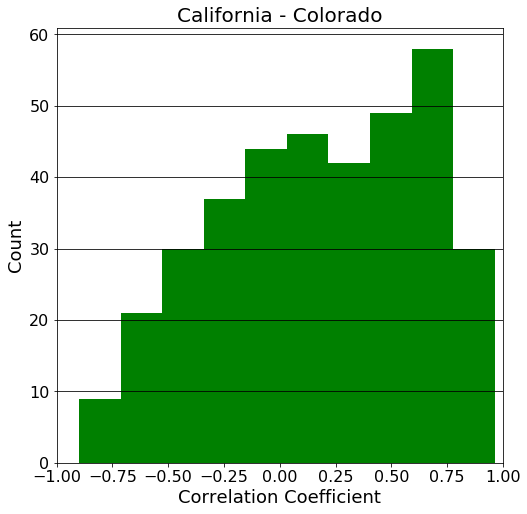

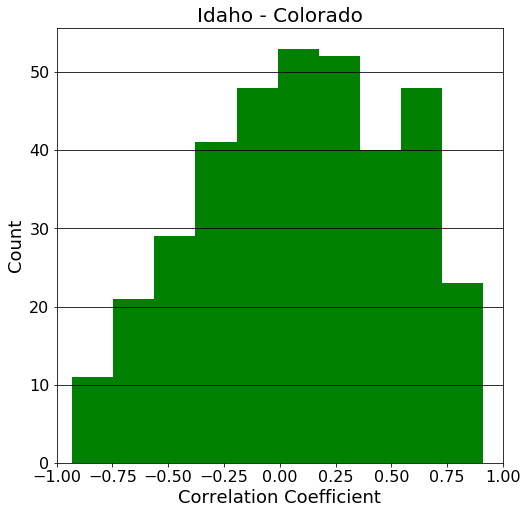

In [22]:
import itertools
pairs = list(itertools.combinations(data_corr_wind['wind'].columns.tolist(), 2))
for i, p in enumerate(pairs):
    fig = plt.figure(figsize=(8, 8))
    plt.hist([corr[i].loc[p[0]][p[1]] for i in range(len(corr))], 10, color='g')
    ax = fig.gca()
    ax.set_xlim([-1,1])
    ax.set_facecolor('white')
    ax.grid(color='black', axis='y')
    ax.tick_params(labelsize=16)
    ax.set_xlabel('Correlation Coefficient', fontsize=18)
    ax.set_ylabel('Count', fontsize=18)
    plt.title(" - ".join(p), fontsize=20)    
plt.show()